# Data Exploration

---

## Import packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib

---

## Setup Folders
As always we start with specifying the data paths:

In [2]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'switchdrive', 'Biozentrum', 'Andreas')

processed_dir = proj_dir / 'processed'
data_dir = proj_dir / 'output'

---

## Load Data
We load the data from the last notebook;

In [3]:
#load data frame
df_name = data_dir / 'caulobacter_combined_data.csv'
df = pd.read_csv(df_name, index_col=0)

#add unique id of cell by combining strain and replicate
df['uni_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_cell'].map(str)
df['uni_par_id'] = df['strain'].map(str) + '-' + df['replicate'].map(str) + '-' + df['id_par'].map(str)
df.head()


,id_seg,id_cell,id_par,id_colony,id_d1,id_d2,id_sib,frames,new_pole,old_pole,...,fluo2,x_pos,y_pos,generation,age,strain,movie_name,replicate,uni_id,uni_par_id
0,0,0,-1,0,-1,-1,-1,0,[ 4 706],[ 2 706],...,411.577778,705.777778,2.955556,0.0,0,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
1,0,0,-1,0,-1,-1,-1,1,[ 4 700],[ 3 700],...,400.348837,700.255814,2.813953,0.0,1,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
2,0,0,-1,0,-1,-1,-1,2,[ 3 705],[ 0 699],...,372.648649,702.243243,2.405405,0.0,2,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
3,0,0,-1,0,-1,-1,-1,3,[ 2 704],[ 2 703],...,371.757576,703.606061,2.242424,0.0,3,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1
4,0,0,-1,0,-1,-1,-1,4,[ 3 704],[ 2 704],...,368.166667,704.047619,2.642857,0.0,4,AKS1088,AKS1088_TL01_01,0,AKS1088-0-0,AKS1088-0--1


Text(0.5, 0, 'life time of cell [frames]')

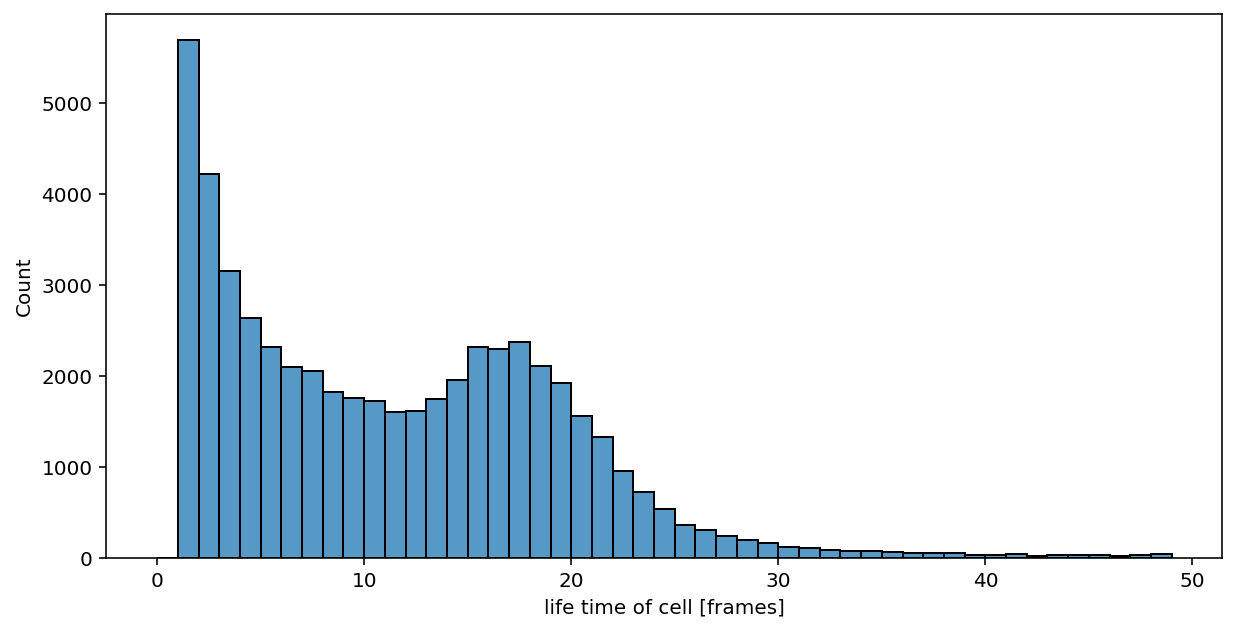

In [4]:
#plot life time of cells
ax = sns.histplot(data=df.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')

---

## Remove incomplete lineages

We only consider full lineages (mothers & daughters tracked)

dropping 295077 measurements, 49.8% remaining


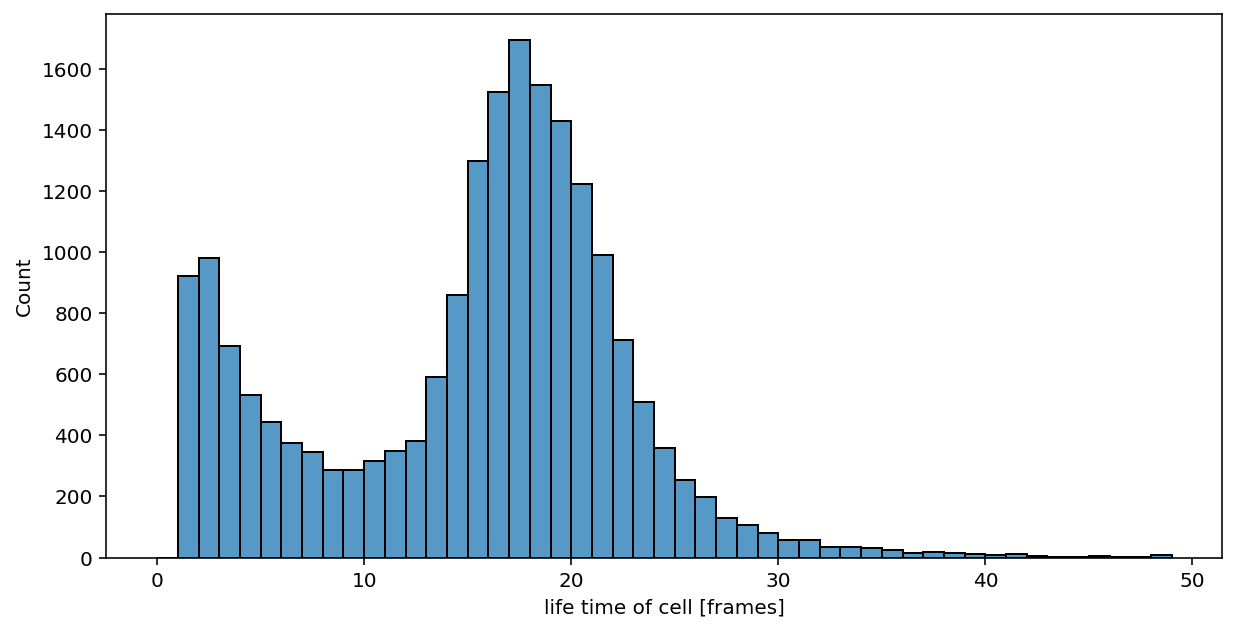

In [5]:
#remove incomplete lineages
has_mom = df["id_par"] > -1
has_d1 = df["id_d1"] > -1
has_d2 = df["id_d2"] > -1
full_lin = has_mom & has_d1 & has_d2

df_compl = df[full_lin].copy()
ax = sns.histplot(data=df_compl.groupby('uni_id').size(), bins=np.arange(50))
ax.set_xlabel('life time of cell [frames]')
print('dropping %i measurements, %.1f%% remaining' % (df.shape[0]-df_compl.shape[0], df_compl.shape[0]/df.shape[0]*100))


---

## Check lineages

We use following checks:
 - We only consider lineages that are around for at least 30 minutes (7 frames)
 - We filter out lineages where the length changes too much.
    - We calculate length change as $\frac{l(t+\Delta t)}{l(t)} = 2^{\Delta t / t_d}$
    - We allow for a max increase of 1.08 (e.q. to $t_d=45$  min), and a max decrease of 0.92.
 - We filter out lineages where length changes too much between division $\frac{l_{d1}+l_{d2}}{l_p}$
 - We filter out lineages where we do not have sibling cell

<AxesSubplot:xlabel='rel_dl', ylabel='Count'>

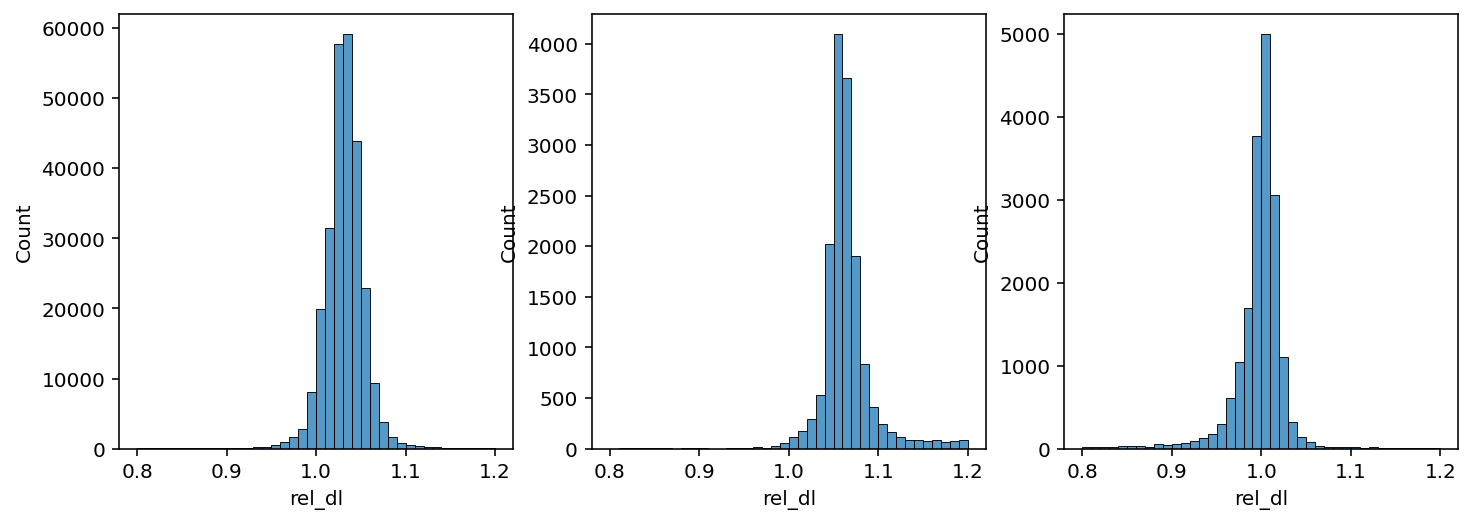

In [6]:
#calc length change
dl = df_compl.groupby('uni_id')['length'].diff()
df_compl['rel_dl'] = (df_compl['length'] + dl)/df_compl['length']
max_dl = df_compl.groupby('uni_id')['rel_dl'].max()
min_dl = df_compl.groupby('uni_id')['rel_dl'].min()

fig, axs = plt.subplots(1,3, figsize=(12,4))
sns.histplot(ax=axs[0], data=df_compl, x='rel_dl', bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[1], data=max_dl, bins=np.linspace(0.8,1.2,41))
sns.histplot(ax=axs[2], data=min_dl, bins=np.linspace(0.8,1.2,41))


In [7]:
#analyze change in length
dl_list = []
movies_grouped = df_compl.groupby('movie_name')

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    for name, cell in cells_grouped:
        
        try:
            sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
            par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
            
            #get length
            len_cel = cell['length'].iloc[0]
            len_sib = movie.loc[sis_idx, 'length'].iloc[0]
            len_par = movie.loc[par_idx, 'length'].iloc[-1]
        
            dl_list.append((len_cel + len_sib) / len_par)
        except:
            continue


<AxesSubplot:ylabel='Count'>

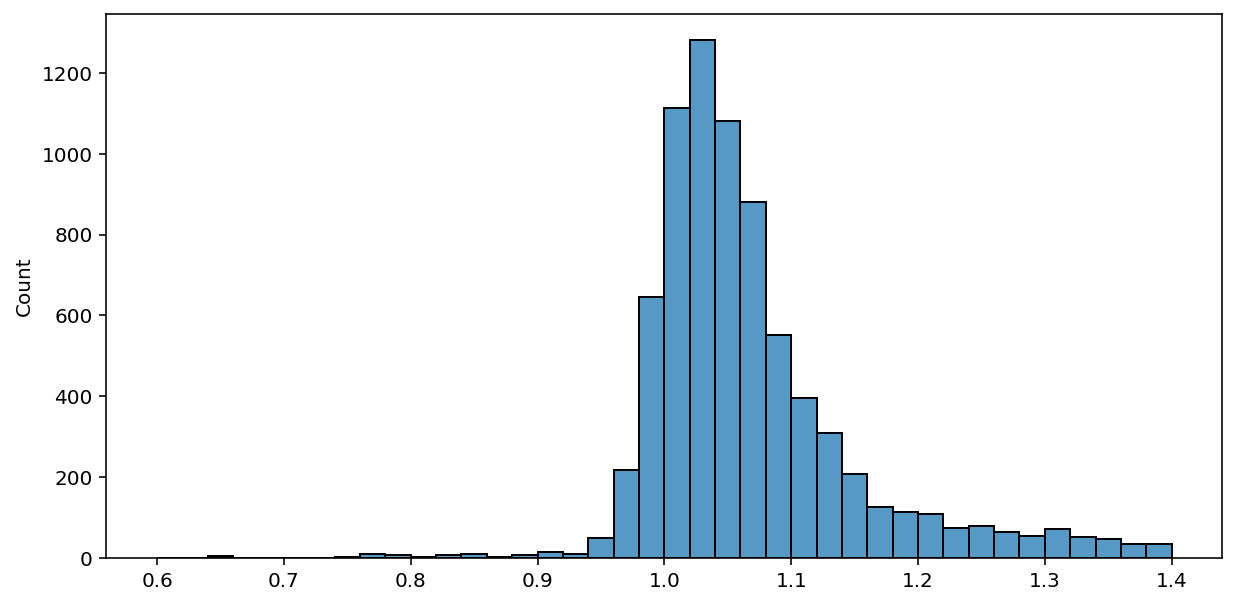

In [8]:
sns.histplot(data=dl_list, bins=np.linspace(0.6,1.4,41))

In [18]:
new_df_list = []

#filter lineages
min_num_frm = 7

#window over which to average cdg levels at end of life / -1 is all life 
av_wndw  = -1

# filter on length change during life time
max_dl = 1.08 #(eq. to td=45min)
min_dl = 0.92

# filter on length change during division
max_dl_div = 1.2 
min_dl_div = 0.94

df_list = []
movies_grouped = df.groupby('movie_name')

cols = ['uni_par_id', 'strain', 'movie_name', 'replicate', 'id_colony', 'id_par',
 'frames', 'generation', 'age']

def check_growth(len):
    dl = len[1:] / len[0:-1]
    return np.all(dl>min_dl) & np.all(dl<max_dl)

reason_skipped = []
lut = []

for name, movie in movies_grouped:
    cells_grouped = movie.groupby('uni_id')
    
    par_id_done = []
    
    for name, cell in cells_grouped:  
        par_id = cell["id_par"].iloc[0]
        if par_id in par_id_done:
            reason_skipped.append(-2)   
        
        else:
            #check if full lineage
            has_mom = par_id > -1
            has_d1 = cell["id_d1"].iloc[0] > -1
            has_d2 = cell["id_d2"].iloc[0] > -1
            full_lin = has_mom & has_d1 & has_d2
            
            if not full_lin: reason_skipped.append(1)

            if full_lin:
                #check if there is sister
                sis_idx = movie['id_cell'] == cell['id_sib'].iloc[0]
                par_idx = movie['id_cell'] == cell['id_par'].iloc[0]
                has_sib = sis_idx.sum()>0
                if not has_sib: reason_skipped.append(2)
                
                if has_sib:
                    #check if there are enough frames
                    len_cel = cell['length']
                    len_sib = movie.loc[sis_idx, 'length']
                    len_ok = (len_cel.size >= min_num_frm) & (len_sib.size >= min_num_frm) 
                    if not len_ok: reason_skipped.append(3)

                    if len_ok:
                        #check length across division                         
                        dl = (len_cel.iloc[0] + len_sib.iloc[0]) / movie.loc[par_idx, 'length'].iloc[-1]
                        div_ok = (dl > min_dl_div) &  (dl < max_dl_div)
                        if not div_ok: reason_skipped.append(4)
                        
                        if div_ok:
                            #check length of cells 
                            frms = np.arange(min(len_cel.size, len_sib.size))
                            
                            len_cel = len_cel.iloc[frms].values 
                            len_sib = len_sib.iloc[frms].values
                            
                            len1_ok = check_growth(len_cel)
                            len2_ok = check_growth(len_sib)
                            if not len1_ok: reason_skipped.append(5)
                            if not len2_ok: reason_skipped.append(6)

                            if len1_ok & len2_ok:
                                #cell pair ok, process
                                par_id_done.append(par_id) 
                                reason_skipped.append(-1)
                                sib_n = cell['id_sib'].iloc[0]
                                cel_n = cell['id_cell'].iloc[0]
                                
                                #copy data frame                    
                                new_df = cell.iloc[frms, df.columns.get_indexer(cols)].reset_index(drop=True)
                                
                                #get fluorescent values
                                fluo_cel = cell['fluo1'].iloc[frms].values 
                                fluo_sib = movie.loc[sis_idx, 'fluo1'].iloc[frms].values 

                                #calc fluorescence ratio
                                rel_fluor = fluo_cel / fluo_sib
                                av_frms = min(av_wndw, rel_fluor.size)
                                fluo_ratio = rel_fluor.mean() if av_frms==-1 else rel_fluor[-av_frms:].mean()
                                
                                #order d1 and d2 based on cdg levels
                                has_high_cdg = True if fluo_ratio>1 else False
                                
                                #normalize fluor
                                max_fluor = fluo_cel[0] if fluo_ratio>1 else fluo_sib[0]
                                fluo_cel_norm = fluo_cel / max_fluor
                                fluo_sib_norm = fluo_sib / max_fluor
                                
                                #d1 should be old pole
                                par_d1 = movie.loc[par_idx, 'id_d1'].iloc[0]
                                is_old = cel_n == par_d1
                                
                                new_df['high_in_old'] = 1 if (is_old & has_high_cdg) else 0
                                
                                #add new fields to df
                                new_df['cdg_old'] =  fluo_cel if is_old else fluo_sib
                                new_df['cdg_new'] =  fluo_sib if is_old else fluo_cel
                                
                                new_df['cdg_norm_old'] =  fluo_cel_norm if is_old else fluo_sib_norm
                                new_df['cdg_norm_new'] =  fluo_sib_norm if is_old else fluo_cel_norm
                                
                                new_df['cdg_dh'] =  fluo_cel if has_high_cdg  else fluo_sib
                                new_df['cdg_dl'] =  fluo_sib if has_high_cdg  else fluo_cel
                                        
                                new_df['cdg_norm_dh'] =  fluo_cel_norm if has_high_cdg  else fluo_sib_norm
                                new_df['cdg_norm_dl'] =  fluo_sib_norm if has_high_cdg  else fluo_cel_norm
                                
                                new_df['len_dh'] =  len_cel if has_high_cdg  else len_sib
                                new_df['len_dl'] =  len_sib if has_high_cdg  else len_cel
                                
                                new_df['idc_dh'] =  cel_n if has_high_cdg  else sib_n
                                new_df['idc_dl'] =  sib_n if has_high_cdg  else cel_n
                                
                                new_df['rel_cdg'] = fluo_cel/fluo_sib if has_high_cdg else fluo_sib/fluo_cel
                                
                                new_df_list.append(new_df)
                                

                 
    
             

In [33]:
a = np.array(reason_skipped)
print(np.sum(a==-1), np.sum(a==-2))

4429 3909


<AxesSubplot:ylabel='Count'>

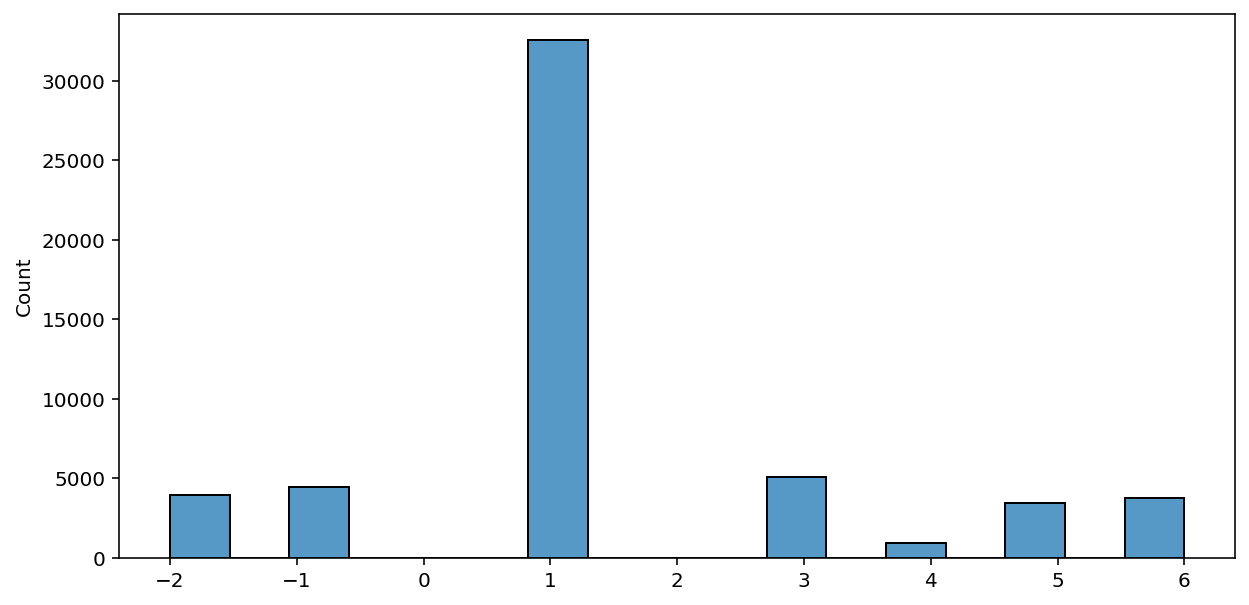

In [19]:
sns.histplot(reason_skipped)

In [20]:
df_paired = pd.concat(new_df_list)

In [14]:
df_paired.head()

,uni_par_id,strain,movie_name,replicate,id_colony,id_par,frames,generation,age,cdg_d1,cdg_d2,cdg_norm_d1,cdg_norm_d2,len_d1,len_d2,idc_d1,idc_d2,rel_cdg
0,AKS1088-0-99,AKS1088,AKS1088_TL01_01,0,30,99,4,1.0,0,498.574545,508.944186,1.000000,1.020799,38.155479,30.224384,247,100,0.979625
1,AKS1088-0-99,AKS1088,AKS1088_TL01_01,0,30,99,5,1.0,1,493.422535,495.450893,0.989667,0.993735,39.082878,31.386862,247,100,0.995906
2,AKS1088-0-99,AKS1088,AKS1088_TL01_01,0,30,99,6,1.0,2,500.161512,512.426778,1.003183,1.027784,39.650173,32.200001,247,100,0.976064
3,AKS1088-0-99,AKS1088,AKS1088_TL01_01,0,30,99,7,1.0,3,479.476974,515.524000,0.961696,1.033996,40.208679,33.384285,247,100,0.930077
4,AKS1088-0-99,AKS1088,AKS1088_TL01_01,0,30,99,8,1.0,4,490.732484,511.780303,0.984271,1.026487,41.959156,35.382584,247,100,0.958873


<AxesSubplot:xlabel='strain'>

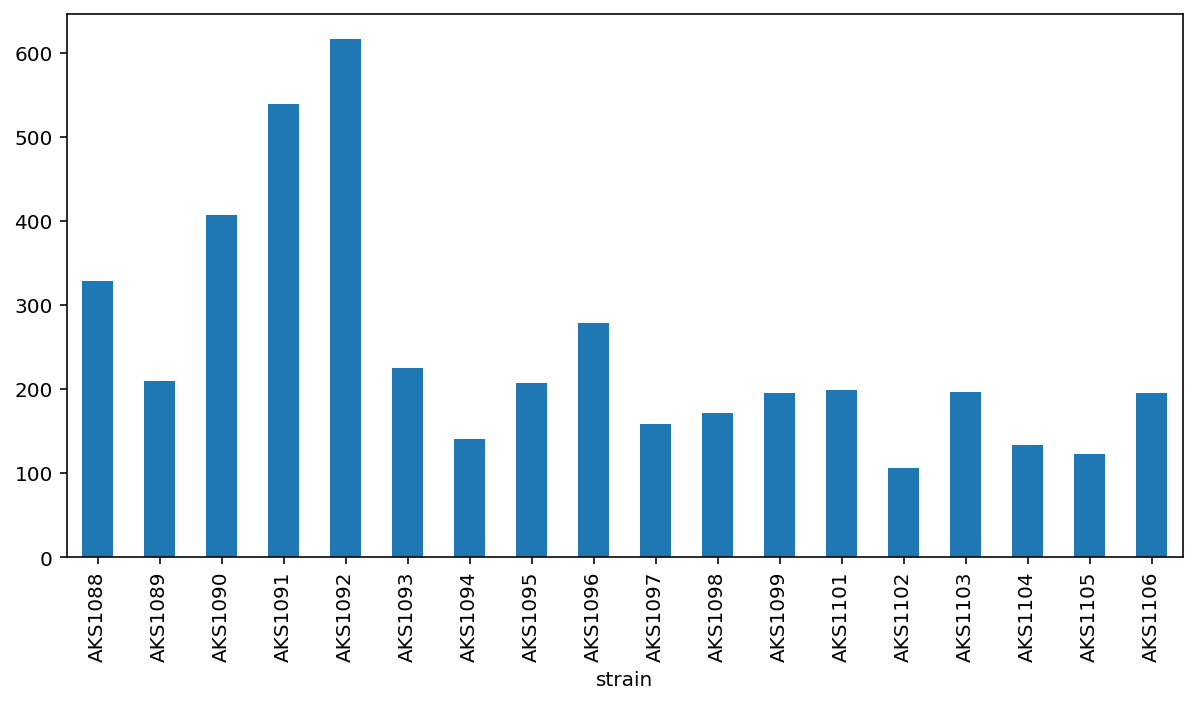

In [21]:
first_frame = df_paired.groupby('uni_par_id').first()
num_lin_per_strain = first_frame.groupby('strain').size() 
num_lin_per_strain.head(n=18)
num_lin_per_strain.plot(kind='bar')


In [22]:
num_lin_per_strain

strain
AKS1088    329
AKS1089    209
AKS1090    407
AKS1091    539
AKS1092    616
AKS1093    225
AKS1094    141
AKS1095    207
AKS1096    279
AKS1097    158
AKS1098    171
AKS1099    195
AKS1101    199
AKS1102    106
AKS1103    197
AKS1104    133
AKS1105    123
AKS1106    195
dtype: int64

## Save paired data

In [23]:
out_name = processed_dir / 'caulobacter_combined_filtered_paired_data.csv'
df_paired.to_csv(out_name)